# Universidade Federal de Santa Catarina
## Programa de Pós-Graduação em Engenharia Elétrica
###  Trabalho 1 - PDSB
### Discentes:

*   Carlos André Antunes
*   João Lucas Pereira dos Santos de Paula
*   Shirley Karolina da Silva Ferreira

# Imports

In [1]:
!pip install altair_viewer -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 844.5/844.5 kB 6.6 MB/s eta 0:00:00


In [2]:
!pip install control

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.1/455.1 kB 7.8 MB/s eta 0:00:00


In [3]:
import altair as alt
alt.renderers.enable('altair_viewer', inline=True)

RendererRegistry.enable('altair_viewer')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import filtfilt
from scipy.fft import fft,fftfreq
import math
import control
from scipy.signal import butter, freqz

##  1 - Aplicar a autocorrelação para detecção de sinais na presença de ruído:
* x1 = senóide 1Vpp, 17Hz.

* x2 = ruído aleatório 5Vpp

* Sampling Frequency 1000 samples/sec

* x(t) = x1(t) + x2(t)


### Geração do sinal

In [5]:
# Parâmetros
fs = 1000  # frequência de amostragem (samples/sec)
T = 1/fs  # período de amostragem
t = np.arange(0, 1, T)  # vetor de tempo

# Sinal x1(t) - senoide de 1Vpp a 17Hz
A1 = 0.5  # amplitude 0.5 para obter 1Vpp (pico a pico)
f1 = 17  # frequência
x1 = A1 * np.sin(2 * np.pi * f1 * t)

# Ruído x2(t) - ruído aleatório com amplitude de 5Vpp
A2 = 2.5  # amplitude 2.5 para obter 5Vpp (pico a pico)
x2 = A2 * (2 * np.random.random(len(t)) - 1)

# Sinal combinado x(t) = x1(t) + x2(t)
x = x1 + x2


### Plot

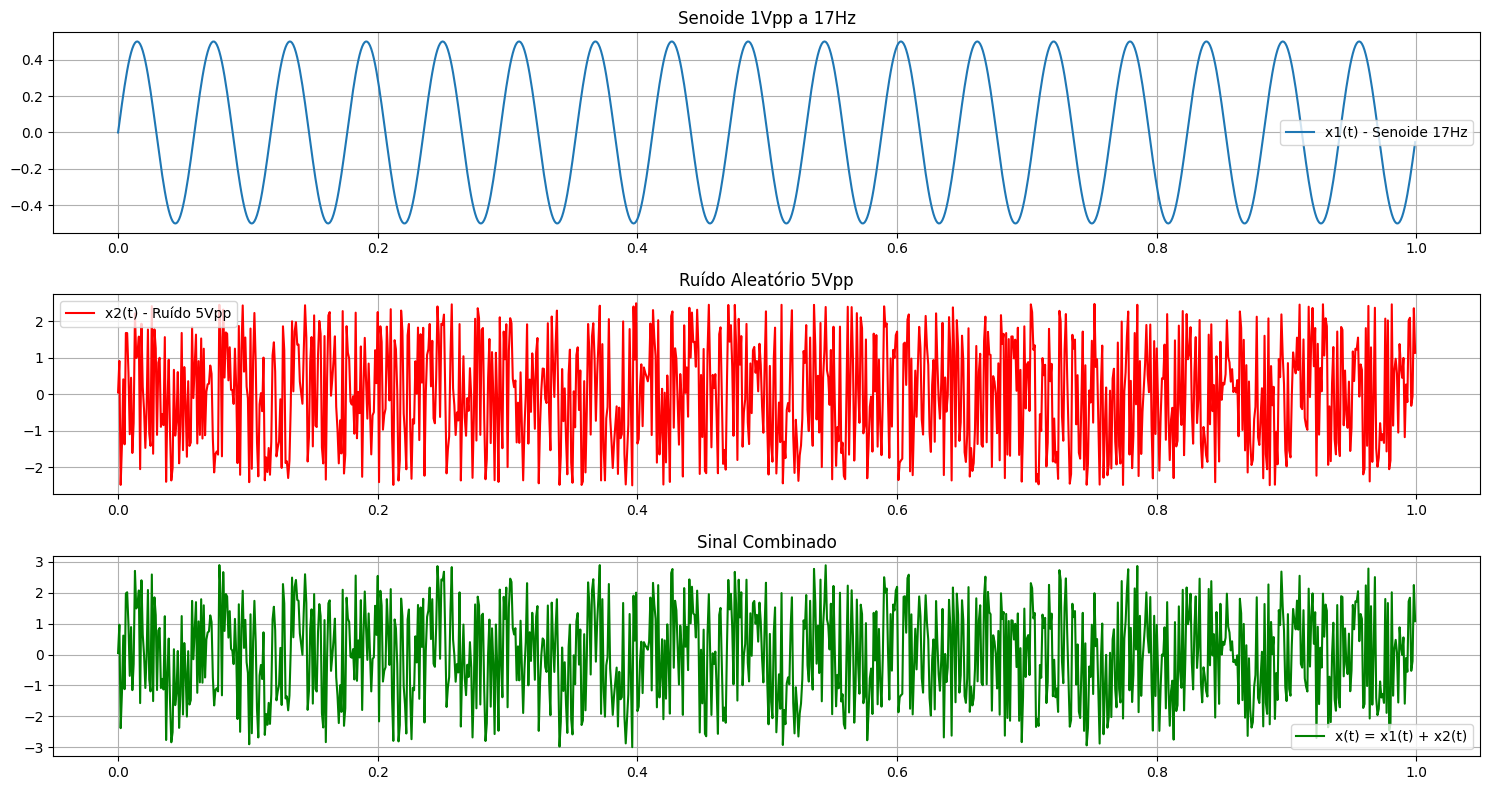

In [6]:
# Plotando os sinais
plt.figure(figsize=(15, 8))
plt.subplot(3, 1, 1)
plt.plot(t, x1, label='x1(t) - Senoide 17Hz')
plt.title('Senoide 1Vpp a 17Hz')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, x2, label='x2(t) - Ruído 5Vpp', color='red')
plt.title('Ruído Aleatório 5Vpp')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, x, label='x(t) = x1(t) + x2(t)', color='green')
plt.title('Sinal Combinado')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Autocorrelação

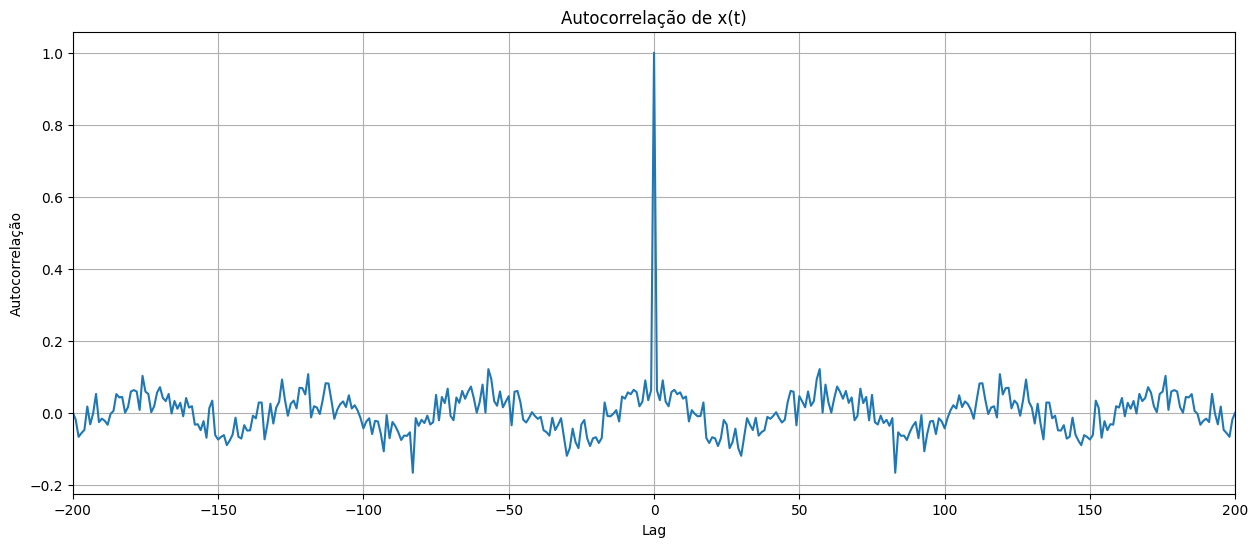

In [7]:
def autocorrelation(signal):
    n = len(signal)
    result = np.zeros(2*n - 1)
   # p = int(0.5*n)
    # signal_zeros = np.concatenate((signal[0:p], np.zeros(n-p)))
    for tau in range(-n + 1, n):
        if tau < 0:
            result[tau + n - 1] = np.sum(signal[:tau+n] * signal[-tau:])
        else:
            result[tau + n - 1] = np.sum(signal[tau:] * signal[:n-tau])
    return result*(1/n)

# propriedade:
#r11 = autocorrelation(x1)
#r22 = autocorrelation(x2)
#rxx = r11+r22

# Calculando a autocorrelação usando nossa função
correlation_custom = autocorrelation(x)
correlation_custom /= np.max(correlation_custom)  # Normalizando para [-1,1]

x_f = fft(correlation_custom)
Nx = len(correlation_custom) # número de amostras (pontos)


# Eixo do tempo para a autocorrelação
lags = np.arange(-len(x) + 1, len(x))

# Plotando a autocorrelação
plt.figure(figsize=(15, 6))
plt.plot(lags, correlation_custom)
plt.title('Autocorrelação de x(t)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelação')
plt.grid(True)
plt.xlim([-200, 200])  # limitando a visualização para -200 a 200 lags para melhor visualização
plt.show()

### Soma das autocorrelações das componentes individuais

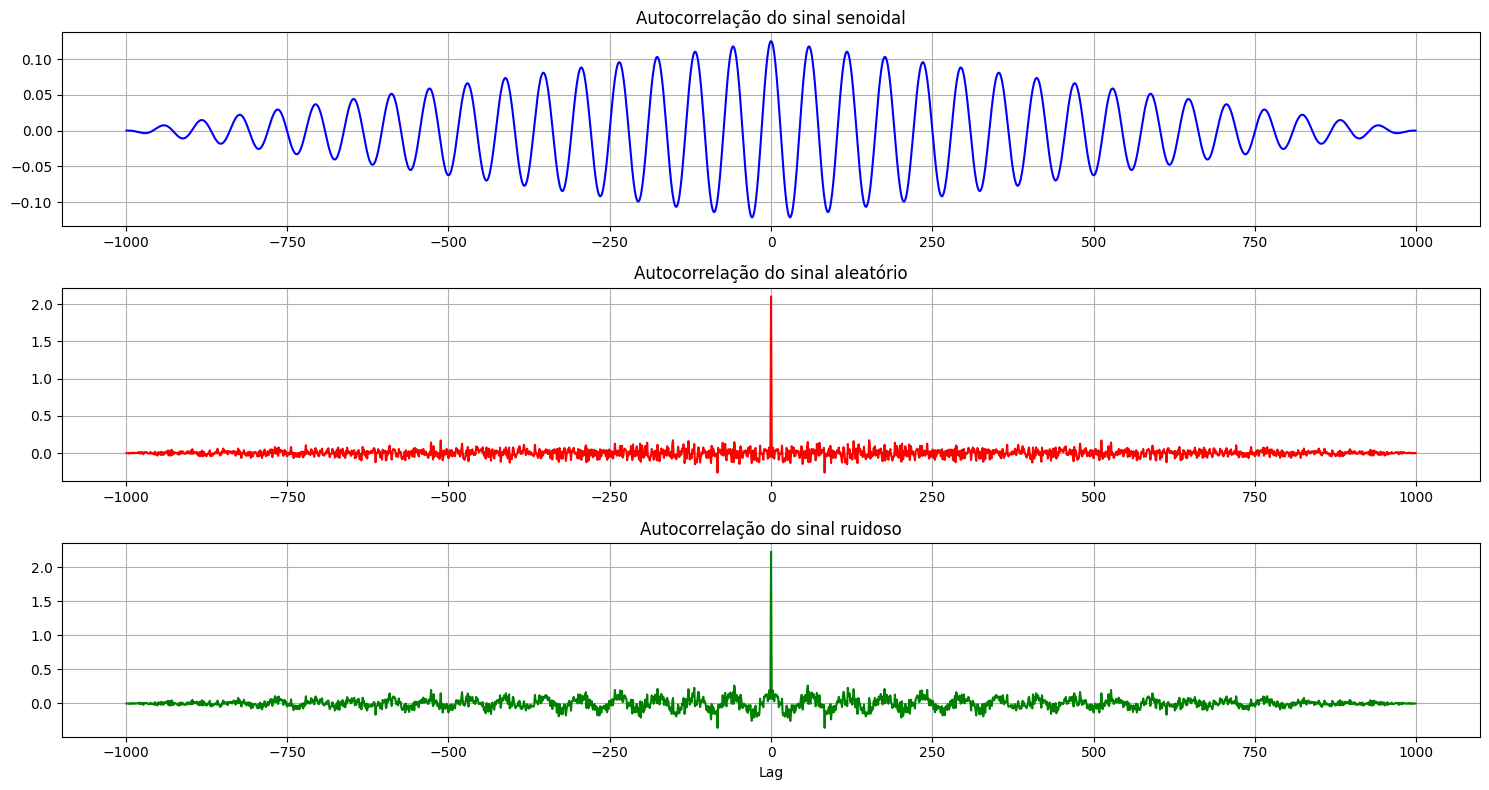

In [8]:
# propriedade:
r11 = autocorrelation(x1)
r22 = autocorrelation(x2)
rxx = r11+r22

plt.figure(figsize=(15, 8))
plt.subplot(3, 1, 1)
plt.plot(lags, r11, color='blue')
plt.title('Autocorrelação do sinal senoidal')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(lags, r22, color='red')
plt.title('Autocorrelação do sinal aleatório')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(lags, rxx, color='green')
plt.title('Autocorrelação do sinal ruidoso')
plt.grid(True)
plt.xlabel('Lag')

plt.tight_layout()
plt.show()

### Espectro da autocorrelação

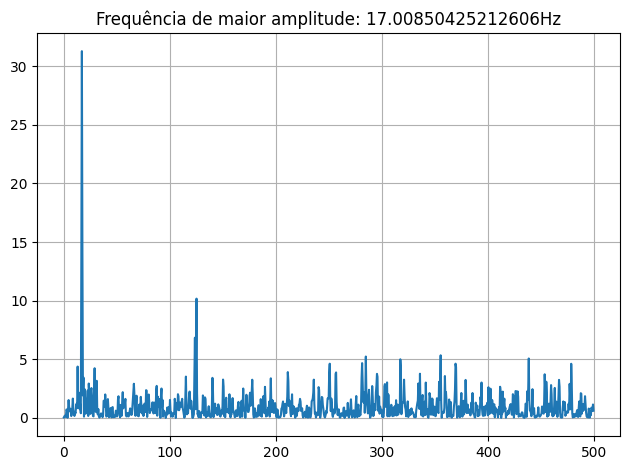

In [9]:
# Espectro da autocorrelação
xs = fft(correlation_custom)
Nx = len(correlation_custom) # número de amostras (pontos)
x_f = fftfreq(Nx, d=1/fs)[:Nx//2]
amp_max = np.argmax(np.abs(xs[0:Nx//2]))
# PLotando
plt.plot(x_f, np.abs(xs[0:Nx//2]))
plt.title(f'Frequência de maior amplitude: {x_f[amp_max]}Hz')
plt.grid(True)
plt.tight_layout()
plt.show()

## 2 - Calcular a convolução digital da seguinte sequência de dados x(t) com a resposta ao impulso do sistema
* h(t).
* x(t) = exp(-0,5.t); 0 <= t <= 32T, T=1
* h(t) = [0 1,5 0,75 0,375 0,1875 0,09375 0,046875 0,0234375]
* Faça o gráfico de x(t), h(t), y(t).

### Gerando sinais

In [10]:
# Definindo a sequência x(t)
t_values = np.arange(0, 33, 1)  # valores de t de 0 a 32 com T=1
x_values = np.exp(-0.5 * t_values)

# Resposta ao impulso h(t)
h_values = np.array([0, 1.5, 0.75, 0.375, 0.1875, 0.09375, 0.046875, 0.0234375])

# Calculando a convolução de x(t) e h(t)
y_values = np.convolve(x_values, h_values, mode='full')

### Plots

<ipython-input-11-5ba5ffb3fa34>:6: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(t_values, x_values, use_line_collection=True)
<ipython-input-11-5ba5ffb3fa34>:12: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(h_values, use_line_collection=True)
<ipython-input-11-5ba5ffb3fa34>:18: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(y_values, use

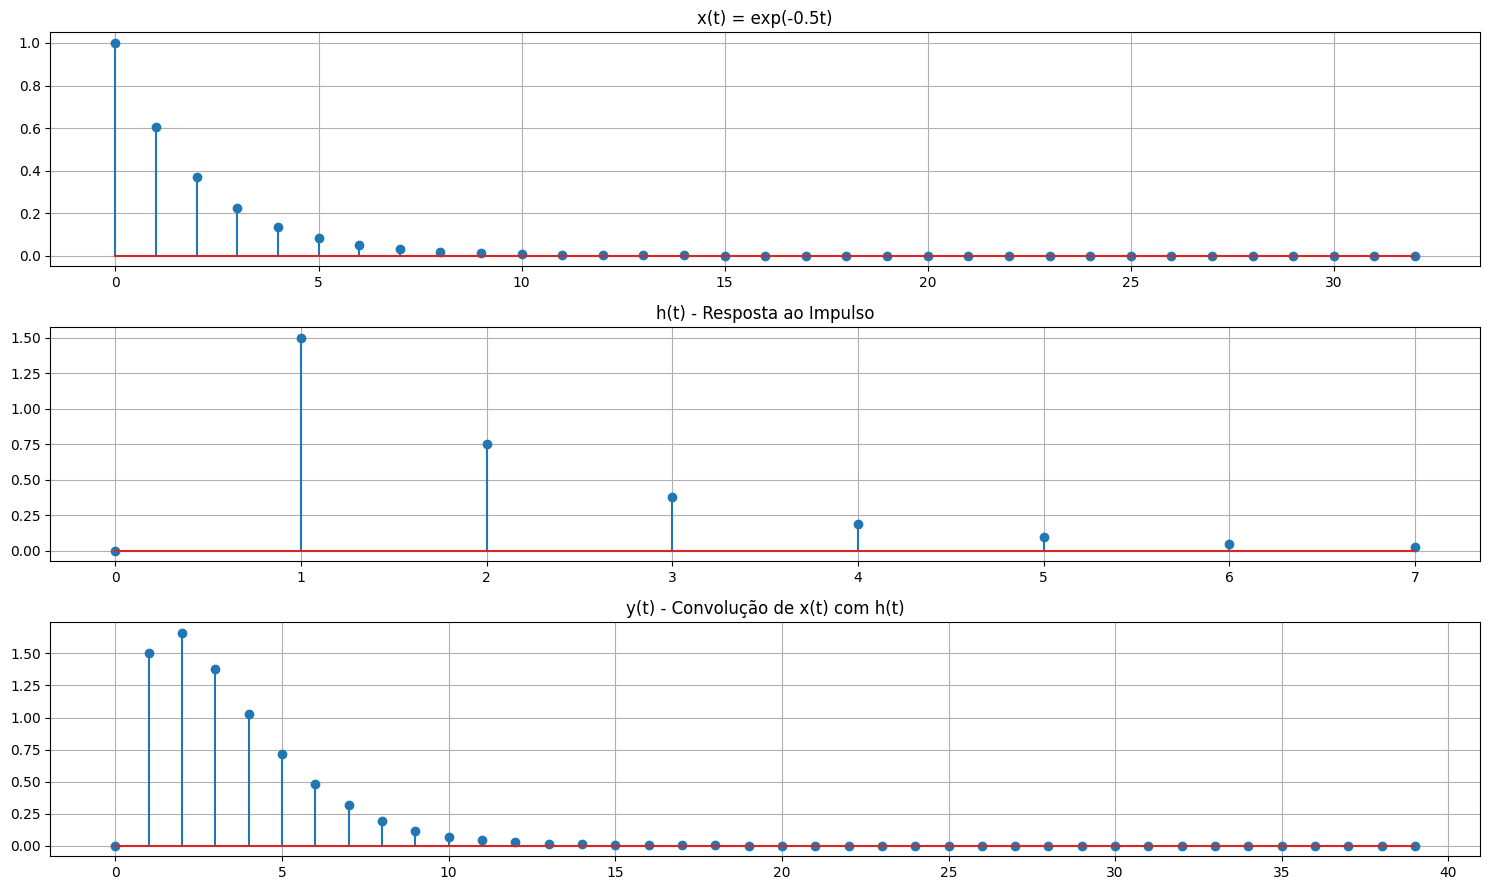

In [11]:
# Plotando x(t), h(t) e y(t)
plt.figure(figsize=(15, 9))

# x(t)
plt.subplot(3, 1, 1)
plt.stem(t_values, x_values, use_line_collection=True)
plt.title('x(t) = exp(-0.5t)')
plt.grid(True)

# h(t)
plt.subplot(3, 1, 2)
plt.stem(h_values, use_line_collection=True)
plt.title('h(t) - Resposta ao Impulso')
plt.grid(True)

# y(t)
plt.subplot(3, 1, 3)
plt.stem(y_values, use_line_collection=True)
plt.title('y(t) - Convolução de x(t) com h(t)')
plt.grid(True)

plt.tight_layout()
plt.show()

## Exercício 3 (Resposta de Frequência de Filtro FIR)

Mostre o gráfico da resposta de frequência do filtro FIR calculado em aula.

Gerar o seguinte sinal:

- S = sin(2.f1.t) + sin(2.f2.t) + sin(2.f3.t), sampling frequency 8kHz, gere 6 s de sinal,
onde:
- f1 = 750 Hz;
- f2 = 2500 Hz;
- f3 = 3250 Hz

Calcule o espectro de frequências de S.

Filtre o sinal S utilizando o filtro projetado, mostrando a saída do filtro e o espectro de frequências do sinal filtrado.

Faça a superposição dos dois espectros calculados acima e avalie os resultados.

In [12]:
# Gerando o sinal S
f1 = 750
f2 = 2500
f3 = 3250
fs = 8000
T = 1/fs  # período de amostragem
t = np.arange(0, 6, T) # vetor de tempo
S = np.sin(2 * np.pi * f1 * t) + np.sin(2 * np.pi * f2 * t) + np.sin(2 * np.pi * f3 * t)

# Espectro de frequência de S
S_f = fft(S)
N = len(S) # número de amostras (pontos)
# xf = fftfreq(N, T)[:N//2] # amostras em frequencia da transformada de fourier = [0, freq de nyquist]
xf = fftfreq(N, d=T)[:N//2]

### Projeto do Filtro FIR

In [13]:
# calculo dos coeficientes do filtro FIR usando o metódo da janela com a função Hamming
f_cutoff = 1500
delta_f = 500
delta_f_normalised = delta_f/fs
print(f'Banda de Transição normalizada:{delta_f_normalised}')
N_coeff = int(np.ceil(3.3/delta_f_normalised))
print(f'Número de coeficientes do filtro FIR:{N_coeff}')
n = np.arange(-(N_coeff-1)/2,(N_coeff-1)/2+1)
print(f'Índices:{n}')

# Devido ao uso da janela, a frequência de corte resultante será diferente da especificada (f_cutoff). Normalizando:
f_cutoff = f_cutoff + delta_f/2
f_cutoff_normalised = f_cutoff/fs
print(f'Nova frequência de corte normalizada:{f_cutoff_normalised}')

hd = np.zeros(int((N_coeff-1)/2)+1)
w = np.zeros(int((N_coeff-1)/2)+1)
h = np.zeros(N_coeff)

for n in range(int((N_coeff-1)/2)+1): # 0 a 26

   if n == 0:
     hd[n] = 2 * f_cutoff_normalised
   else:
     hd[n] = 2 * f_cutoff_normalised * np.sin(n*2*np.pi*f_cutoff_normalised)/(n*2*np.pi*f_cutoff_normalised)

   w[n] = 0.54 + 0.46 * np.cos((2*np.pi*n)/N_coeff)

   h[26-n] = h[n+26] = hd[n] * w[n] # simetria

print(f'Coeficientes do filtro FIR:{h}')

# Filtrando o sinal
S_filtered = np.convolve(h,S)

# espectro do sinal filtrado
Sfiltered_f = fft(S_filtered)
N2 = len(Sfiltered_f) # número de amostras (pontos)
xf2 = fftfreq(N2, d=T)[:N2//2]

Banda de Transição normalizada:0.0625
Número de coeficientes do filtro FIR:53
Índices:[-26. -25. -24. -23. -22. -21. -20. -19. -18. -17. -16. -15. -14. -13.
 -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.]
Nova frequência de corte normalizada:0.21875
Coeficientes do filtro FIR:[-9.13999286e-04  2.16735904e-04  1.32702791e-03  3.21384890e-04
 -1.92381700e-03 -1.46836488e-03  2.36273006e-03  3.48465725e-03
 -1.99258075e-03 -6.28372375e-03  6.69689127e-18  9.26694478e-03
  4.34306381e-03 -1.12712950e-02 -1.14024577e-02  1.06307073e-02
  2.09643945e-02 -5.25831286e-03 -3.21560849e-02 -7.54498078e-03
  4.35461478e-02  3.25931980e-02 -5.34136435e-02 -8.56820327e-02
  6.01221331e-02  3.11185673e-01  4.37500000e-01  3.11185673e-01
  6.01221331e-02 -8.56820327e-02 -5.34136435e-02  3.25931980e-02
  4.35461478e-02 -7.54498078e-03 -3.21560849e-02 -5.

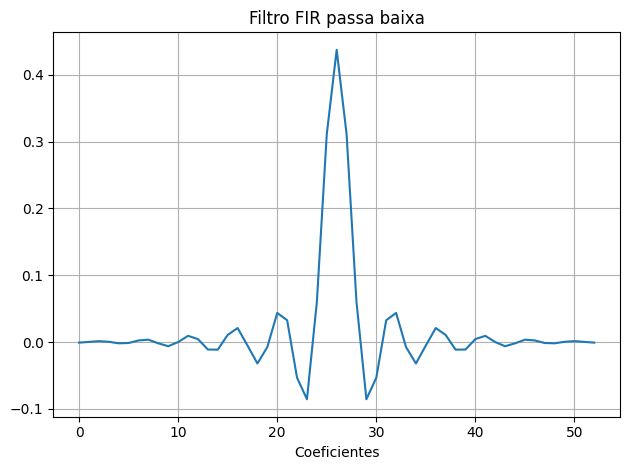

In [14]:
# Plot da janela
plt.plot(h)
plt.title('Filtro FIR passa baixa')
plt.xlabel('Coeficientes')
plt.grid(True)
plt.tight_layout()
plt.show()

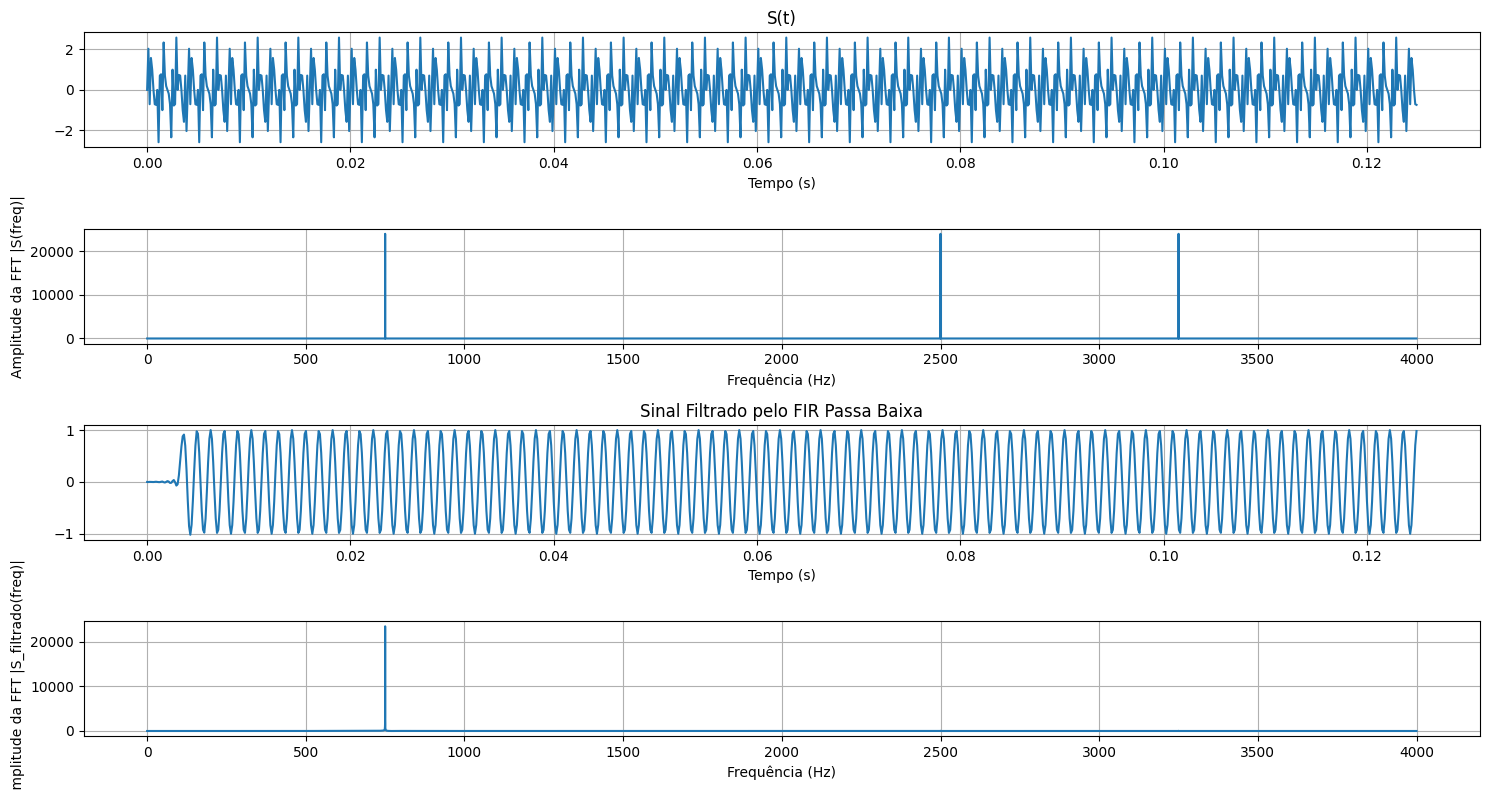

In [15]:
# Plot do sinal e do seu espectro de frequência
plt.figure(figsize=(15, 8))
plt.subplot(4, 1, 1)
plt.plot(t[0:1000], S[0:1000], label='S(t)')
plt.title('S(t)')
plt.grid(True)
plt.xlabel('Tempo (s)')

plt.subplot(4,1,2)
# plt.plot(xf, 2.0/N * np.abs(S_f[0:N//2]), label='S(f)')
plt.plot(xf, np.abs(S_f[0:N//2]), label='S(f)')
plt.grid(True)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude da FFT |S(freq)|')


plt.subplot(4, 1, 3)
plt.plot(t[0:1000], S_filtered[0:1000])
plt.title('Sinal Filtrado pelo FIR Passa Baixa')
plt.grid(True)
plt.xlabel('Tempo (s)')

plt.subplot(4,1,4)
# plt.plot(xf, 2.0/N * np.abs(S_f[0:N//2]), label='S(f)')
plt.plot(xf2, np.abs(Sfiltered_f[0:N2//2]))
plt.grid(True)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude da FFT |S_filtrado(freq)|')


plt.tight_layout()
plt.show()

## Exercício 4 (Colocação de Pólos e Zeros no Plano Z)

Usando o método da colocação de pólos e zeros no plano Z (use o sinal de ECG de 15 segundos @ 500 Hz, ECGtest03.txt):

Calcule os coeficientes do filtro notch.

Obtenha a função de transferência, a equação de diferenças e a representação em blocos para a seguinte especificação:

- Notch frequency 60 Hz
- 3dB width of notch 5 Hz
- Sampling frequency 1200 Hz ou alguma frequência múltipla de 60 Hz.

Filtre o sinal de ECG original utilizando o filtro projetado e avalie e mostre os resultados.

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
ECGtest03 = "/content/drive/MyDrive/PDSB/ECG and PPG Signals-20231021/ECGtest03.txt"

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import lfilter
from scipy.fft import fft

In [19]:
ecg_df = pd.read_csv(ECGtest03,sep="\t", names=["X","Y"])
ecg_df

,X,Y
0,0.000,102.431595
1,0.002,102.524100
2,0.004,102.748390
3,0.006,103.095030
4,0.008,102.858010
...,...,...
240195,480.390,93.686100
240196,480.392,93.444695
240197,480.394,93.791650
240198,480.396,93.861530


<Axes: xlabel='X'>

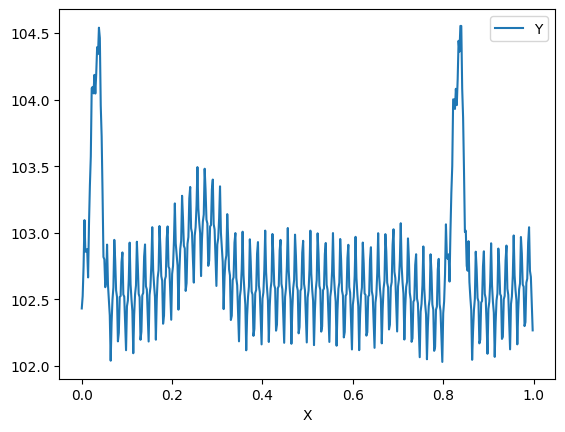

In [37]:
ecg_df.iloc[:500].plot(x='X', y='Y')

In [21]:
largura_banda_3dB = 10
frequencia_notch = 60
# Calcular a frequência de amostragem
tempo = ecg_df["X"].to_numpy()
frequencia_amostragem = 1 / (tempo[1] - tempo[0])

frequencia_amostragem

500.0

In [22]:
amplitude = ecg_df["Y"].to_numpy()

# Criar uma função de interpolação
interp_funcao = interp1d(tempo, amplitude, kind='linear')

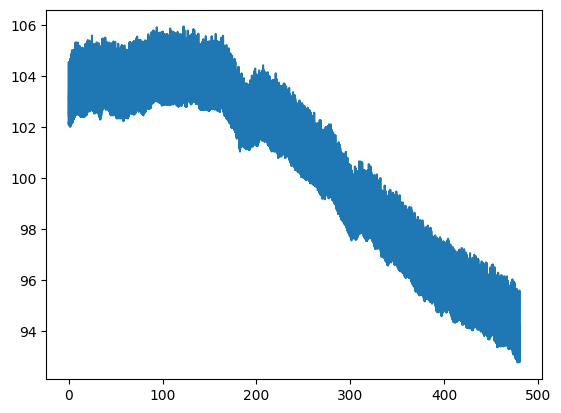

In [23]:
nova_frequencia_amostragem_1200Hz = 1200 # 1200 Hz

# Gerar novos pontos de tempo para a nova frequência de amostragem
tempo_reamostrado_1200Hz = np.arange(tempo[0], tempo[-1], 1/nova_frequencia_amostragem_1200Hz)

# Interpolar para obter os novos valores de amplitude
amplitude_reamostrada_1200Hz = interp_funcao(tempo_reamostrado_1200Hz)

# Mostrar algumas informações básicas sobre os dados reamostrados
pd.DataFrame({
    "Tempo (s)": tempo_reamostrado_1200Hz[:5],
    "Amplitude": amplitude_reamostrada_1200Hz[:5]
})
plt.plot(tempo_reamostrado_1200Hz, amplitude_reamostrada_1200Hz, label="ECG Original")

In [24]:
# Calcular o raio dos polos (r) para a nova frequência de amostragem
r_1200Hz = 1 - np.pi * largura_banda_3dB / nova_frequencia_amostragem_1200Hz

# Calcular os coeficientes do filtro Notch para a nova frequência de amostragem
b0_1200Hz = 1
b1_1200Hz = -2 * np.cos(2 * np.pi * frequencia_notch / nova_frequencia_amostragem_1200Hz)
b2_1200Hz = 1
a0_1200Hz = 1
a1_1200Hz = -2 * r_1200Hz * np.cos(2 * np.pi * frequencia_notch / nova_frequencia_amostragem_1200Hz)
a2_1200Hz = r_1200Hz**2

# Coeficientes do filtro para a nova frequência de amostragem
b_1200Hz = [b0_1200Hz, b1_1200Hz, b2_1200Hz]
a_1200Hz = [a0_1200Hz, a1_1200Hz, a2_1200Hz]


TF_notch = control.tf(b_1200Hz,a_1200Hz)

# b_1200Hz, a_1200Hz
TF_notch

TransferFunction(array([ 1.        , -1.90211303,  1.        ]), array([ 1.        , -1.85231583,  0.94832551]))

### Diagrama de Bode

(0.0, 600.0)

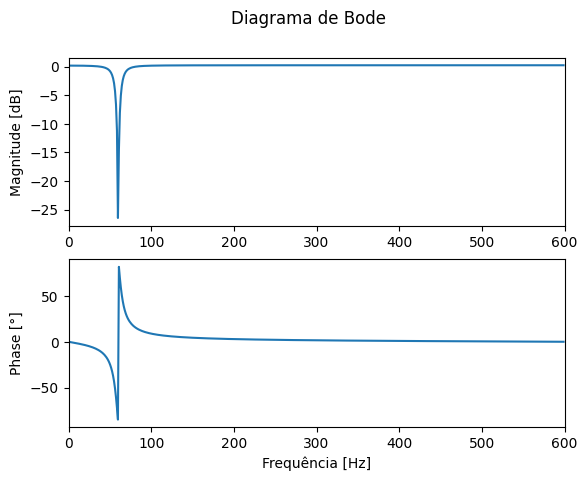

In [25]:
w, h = freqz(b_1200Hz, a_1200Hz) # resposta em frequencia
w *= nova_frequencia_amostragem_1200Hz / (2 * np.pi) # convertendo rad/sample para Hz
# Plotando o diagrama de bode:
plt.subplot(2, 1, 1)
plt.suptitle('Diagrama de Bode')
plt.plot(w, 20 * np.log10(abs(h))) # Convert to dB
plt.ylabel('Magnitude [dB]')
plt.xlim(0, nova_frequencia_amostragem_1200Hz / 2)

plt.subplot(2, 1, 2) # Plot the phase response
plt.plot(w, 180 * np.angle(h) / np.pi) # Convert argument to degrees
plt.xlabel('Frequência [Hz]')
plt.ylabel('Phase [°]')
plt.xlim(0, nova_frequencia_amostragem_1200Hz / 2)

#### Filtro Passa-faixa de 0.4Hz a 40Hz

In [26]:
# Ordem do filtro
order_low = 4
order_high = 3

# faixa de frequencia do filtro
f_low = 40
f_high = 0.04

# calculando os filtros que compoem do passa-faixa
b_low, a_low = butter(order_low, f_low, fs=nova_frequencia_amostragem_1200Hz, btype='lowpass')
b_high, a_high =  butter(order_high, f_high, fs=nova_frequencia_amostragem_1200Hz, btype='highpass')

# Filtrando o sinal pelo passa-alta
ecg_filtrado_1200Hz = filtfilt(b_high, a_high, amplitude_reamostrada_1200Hz)

# Filtrando o sinal pelo passa-baixa
ecg_filtrado_1200Hz = filtfilt(b_low, a_low,ecg_filtrado_1200Hz)

ecg_filtrado_1200Hz

array([ 0.01577395,  0.06445439,  0.1119541 , ..., -0.15354845,
       -0.14058522, -0.12737963])

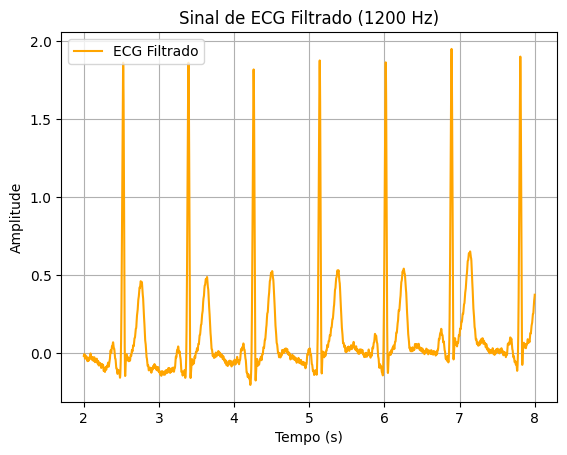

In [27]:
plt.plot(tempo_reamostrado_1200Hz[2400:9600], ecg_filtrado_1200Hz[2400:9600], label="ECG Filtrado", color='orange')
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.title("Sinal de ECG Filtrado (1200 Hz)")
plt.grid(True)
plt.legend()

#### Aplicando o filtro Notch

In [38]:
# Aplicar o filtro Notch ao sinal de ECG reamostrado para 1200 Hz
ecg_filtrado_1200Hz = lfilter(b_1200Hz, a_1200Hz, ecg_filtrado_1200Hz)

# Mostrar algumas amostras do sinal filtrado
pd.DataFrame({
    "Tempo (s)": tempo_reamostrado_1200Hz[:5],
    "ECG Original": amplitude_reamostrada_1200Hz[:5],
    "ECG Filtrado": ecg_filtrado_1200Hz[:5]
})

,Tempo (s),ECG Original,ECG Filtrado
0,0.000000,102.431595,0.015774
1,0.000833,102.470139,0.062883
2,0.001667,102.508683,0.104294
3,0.002500,102.580173,0.140695
4,0.003333,102.673627,0.173185


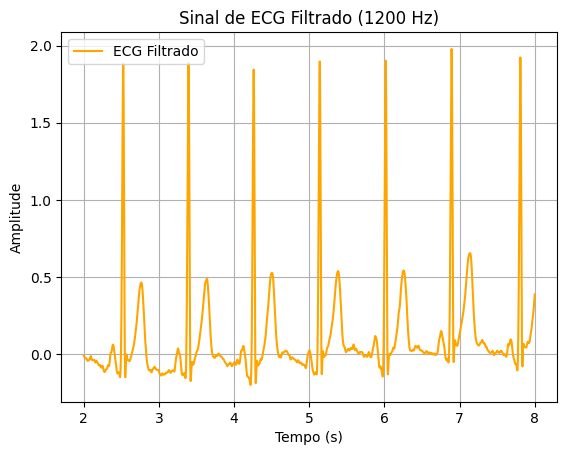

In [29]:
plt.plot(tempo_reamostrado_1200Hz[2400:9600], ecg_filtrado_1200Hz[2400:9600], label="ECG Filtrado", color='orange')
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.title("Sinal de ECG Filtrado (1200 Hz)")
plt.grid(True)
plt.legend()

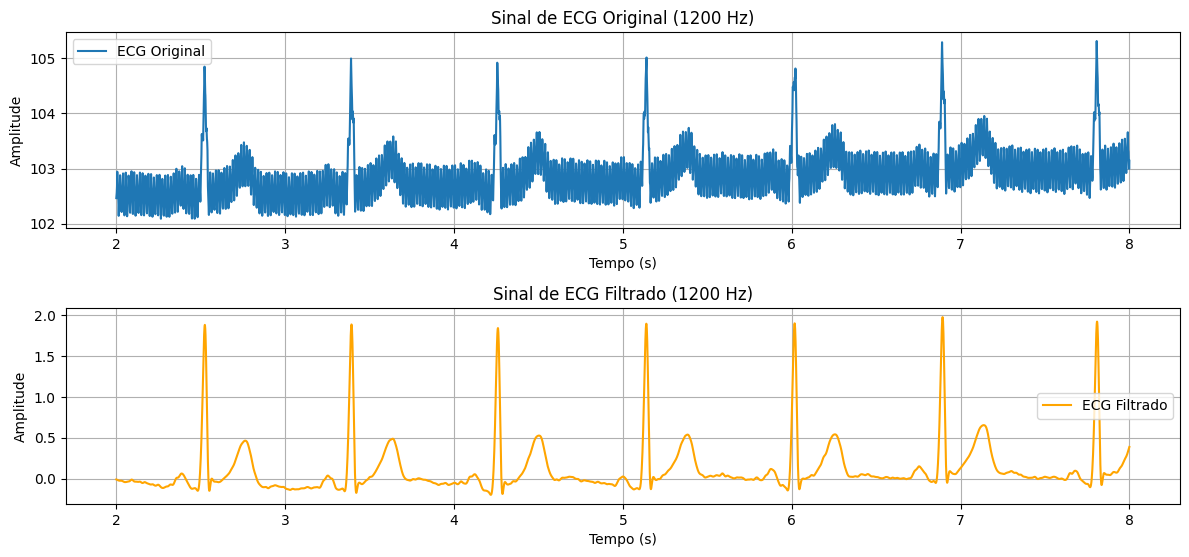

In [30]:
# Configurar o tamanho da figura
plt.figure(figsize=(12, 8))

# Plotar o sinal de ECG original para 1200 Hz
plt.subplot(3, 1, 1)
plt.plot(tempo_reamostrado_1200Hz[2400:9600], amplitude_reamostrada_1200Hz[2400:9600], label="ECG Original")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.title("Sinal de ECG Original (1200 Hz)")
plt.grid(True)
plt.legend()

# Plotar o sinal de ECG filtrado para 1200 Hz
plt.subplot(3, 1, 2)
plt.plot(tempo_reamostrado_1200Hz[2400:9600], ecg_filtrado_1200Hz[2400:9600], label="ECG Filtrado", color='orange')
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.title("Sinal de ECG Filtrado (1200 Hz)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

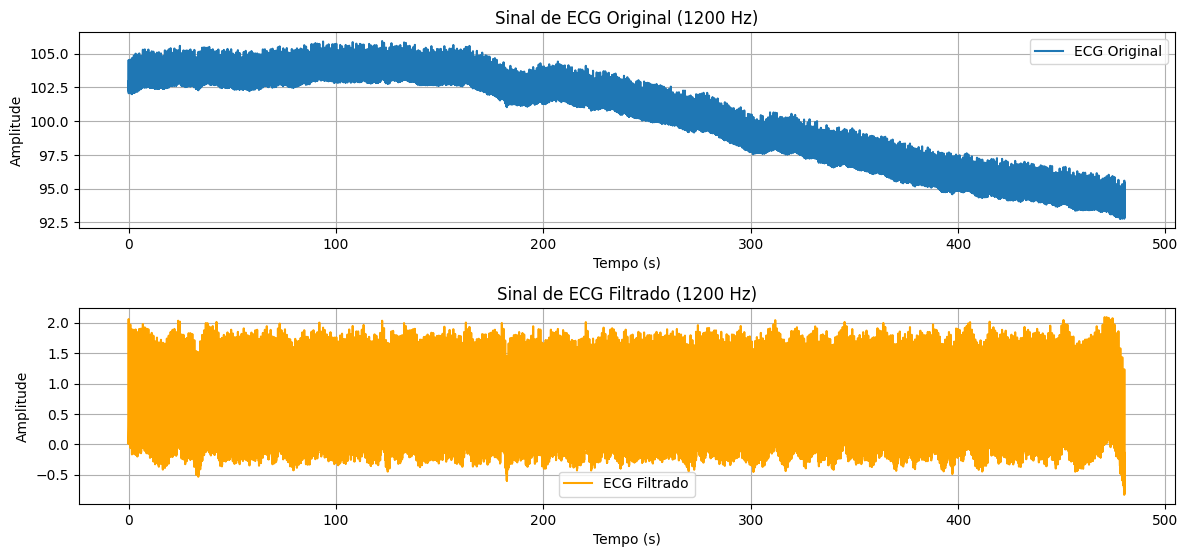

In [31]:
# Configurar o tamanho da figura
plt.figure(figsize=(12, 8))

# Plotar o sinal de ECG original para 1200 Hz
plt.subplot(3, 1, 1)
plt.plot(tempo_reamostrado_1200Hz, amplitude_reamostrada_1200Hz, label="ECG Original")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.title("Sinal de ECG Original (1200 Hz)")
plt.grid(True)
plt.legend()

# Plotar o sinal de ECG filtrado para 1200 Hz
plt.subplot(3, 1, 2)
plt.plot(tempo_reamostrado_1200Hz, ecg_filtrado_1200Hz, label="ECG Filtrado", color='orange')
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.title("Sinal de ECG Filtrado (1200 Hz)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

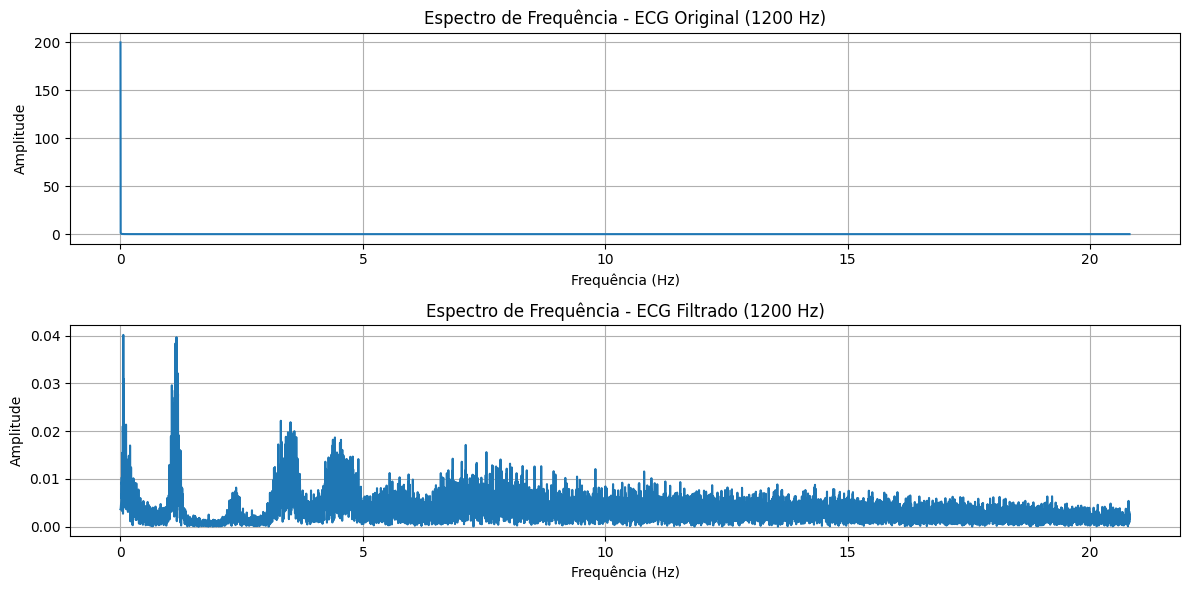

In [35]:
# Função para calcular e plotar o espectro de frequência
def plotar_espectro_de_frequencia(sinal, frequencia_amostragem, titulo):
    n = len(sinal)
    T = 1 / frequencia_amostragem
    yf = fft(sinal)
    xf = fftfreq(n, T)[:n//2]
    plt.plot(xf[0:10000], 2.0/n *np.abs(yf[0:n//2])[0:10000])
    plt.grid()
    plt.title(titulo)
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Amplitude')

# Configurar o tamanho da figura
plt.figure(figsize=(12, 6))

# Espectro de frequência do sinal de ECG original para 1200 Hz
plt.subplot(2, 1, 1)
plotar_espectro_de_frequencia(amplitude_reamostrada_1200Hz, nova_frequencia_amostragem_1200Hz, "Espectro de Frequência - ECG Original (1200 Hz)")

# Espectro de frequência do sinal de ECG filtrado para 1200 Hz
plt.subplot(2, 1, 2)
plotar_espectro_de_frequencia(ecg_filtrado_1200Hz, nova_frequencia_amostragem_1200Hz, "Espectro de Frequência - ECG Filtrado (1200 Hz)")

plt.tight_layout()
plt.show()